# <a id='toc1_'></a>[Capstone 3: Predicting Machinery Unbalance using Vibration Data](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Capstone 3: Predicting Machinery Unbalance using Vibration Data](#toc1_)    
  - [Abstract](#toc1_1_)    
  - [Problem Statement: ](#toc1_2_)    
  - [About the Data](#toc1_3_)    
  - [Summary and Conclusions](#toc1_4_)    
  - [Steps](#toc1_5_)    
  - [Dependencies and Initial Definitions](#toc1_6_)    
  - [Read data](#toc1_7_)    
  - [Exploratory Data Analysis (EDA)](#toc1_8_)    
    - [Data Processing Method Summary](#toc1_8_1_)    
  - [Model Data Preparation](#toc1_9_)    
  - [Model Evaluation](#toc1_10_)    
  - [Concern areas](#toc1_11_)    
  - [Suggestions and Improvements](#toc1_12_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Abstract](#toc0_)

The use of machinery vibration and the technological advances that have been developed over the years, that make it possible to not only detect when a machine is developing a problem, but to identify the specific nature of the problem for scheduled correction.
<br>Fault detection at rotating machinery with the help of vibration sensors offers the possibility to detect damage to machines at an early stage and to prevent production down-times by taking appropriate measures.
<br>The following Kaggle dataset consists of pairs of training and test data for different levels of vibration imbalances created by varying amounts of unbalance (unbalance load) on the shaft. The output of vibration sensors corresponding to the various unbalances are provided.
<br>The goal is to determine if such data can be used to predict worsening or damaged motor arrangement using machine learning

## <a id='toc1_2_'></a>[Problem Statement: ](#toc0_)

<b><i>How can vibration data be used to predict possible damage to rotating  shaft and machinery?</i></b>

## <a id='toc1_3_'></a>[About the Data](#toc0_)

<p>A shaft attached to a motor was setup to rotate in a bearing. The other end of the shaft was connected to a load platform. The bearing had three PCB Synotech GmbH, type PCB-M607A11 / M001AC vibration sensors sending readings to a DAQ. 
<p>Vibration data for unbalances of different sizes was recorded. The vibration data was recorded at a sampling rate of 4096 values per second. By varying the level of unbalance, different levels of difficulty can be achieved, since smaller unbalances obviously influence the signals at the vibration sensors to a lesser extent.

<p>In total, datasets for 4 different unbalance strengths were recorded as well as one dataset with the unbalance holder without additional weight (i.e. without unbalance). The rotation speed was varied between approx. 630 and 2330 RPM in the development datasets and between approx. 1060 and 1900 RPM in the evaluation datasets. Each dataset is provided as a csv-file with five columns:
<ol>
    <li>. V_in         : The input voltage to the motor controller V_in (in V)
    <li>. Measured_RPM   : The rotation speed of the motor (in RPM; computed from speed measurements using the DT9837)
    <li>. Vibration_1      : The signal from the first vibration sensor
    <li>. Vibration_2     : The signal from the second vibration sensor
    <li>. Vibration_3     : The signal from the third vibration sensor
</ol>
<p>
Overview of the dataset components:
<br>ID	Radius [mm],	Mass [g]
<br>0D/ 0E	-	-
<br>1D/ 1E	14 ± 0.1, 	3.281 ± 0.003
<br>2D/ 2E	18.5 ± 0.1, 	3.281 ± 0.003
<br>3D/ 3E	23 ± 0.1, 	3.281 ± 0.003
<br>4D/ 4E	23 ± 0.1, 	6.614 ± 0.007
<p>
In order to enable a comparable division into a development dataset and an evaluation dataset, separate measurements were taken for each unbalance strength, respectively.
This separation can be recognized in the names of the csv-files, which are of the form “1D.csv”: The digit describes the unbalance strength (“0” = no unbalance, “4” = strong unbalance), and the letter describes the intended use of the dataset (“D” = development or training, “E” = evaluation).

Data Source: https://www.kaggle.com/datasets/jishnukoliyadan/vibration-analysis-on-rotating-shaft/data 
<br>
Reference: 
<br>@inproceedings{inproceedings,
<br>author = {Mey, Oliver and Neudeck, Willi and Schneider, André and Enge-Rosenblatt, Olaf},
<br>year = {2020},
<br>month = {09},
<br>pages = {1610-1617},
<br>title = {Machine Learning-Based Unbalance Detection of a Rotating Shaft Using Vibration Data},
<br>doi = {10.1109/ETFA46521.2020.9212000}
}


<b>Assumption:</b> The data is time ordered

## <a id='toc1_4_'></a>[Summary and Conclusions](#toc0_)

<li> Imported the development and evaluation data from the source 
<li> The data was analyzed and modified to make it suitable for predicting load
<li> Different models were explored  and compared to find the best model for predicting load
<li> A custom metric was developed to evaluate the best model
<li> The best model was found to be a <b>XGB Classifier model</b>


## <a id='toc1_5_'></a>[Steps](#toc0_)

<ol>
<li> Download the development and evaluation data from the  provided link.
<li> Read the development data into a pyspark dataframe
<li> Explore the pyspark dataframe and observe discrepancies (negative RPM and vibrations, etc..)
<li> Group the pyspark dataframe by voltage and load level
<li> Convert the grouped pyspark dataframe to pandas dataframe
<li> Repeat these steps for the evaluation data
<li> Plot the vibration vs. RPM for various load levels for both training and evaluation data and shuffle if necessary to obtain suitable data
<li> Define model metric for evaluation
<li> Split the data into train and test
<li> Develop data pre-processing and modeling pipeline and Grid SearchCV to tune hyperparameters
<li> Fit the search to the training data
<li> Select the model with the best hyperparameters and evaluate on the test data
<li> Plot the confusion matrix and determine the model metric for different models
<li> Choose the model with the highest metric value
</ol>



## <a id='toc1_6_'></a>[Dependencies and Initial Definitions](#toc0_)

In [76]:
import math as mth
import pandas as pd
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SparkSession,DataFrame,functions,types
import pyspark.sql.functions as spark_fn
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score,\
classification_report, roc_curve,auc,confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer,FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,TimeSeriesSplit,GridSearchCV
from xgboost import XGBClassifier,XGBRegressor
import tensorflow as tf
from keras import callbacks
from keras.models import Sequential
from keras.layers import InputLayer,Dense, Flatten,LSTM
# from keras.optimizers import Adam
import scipy
from scipy.stats import linregress
from scipy.stats import pearsonr
import statsmodels
from statsmodels.tsa.stattools import acf
from datetime import datetime, timedelta
import random
import sys
import os
from io import StringIO
import json # library to handle JSON files
from matplotlib import cm,colors
from matplotlib.colors import Normalize
from geopy.geocoders import Nominatim # convert an place into latitude and longitude values
import folium # map rendering library
from bs4 import BeautifulSoup
import camelot
import requests
from IPython import get_ipython

In [77]:
# Create a spark sql session
spark=SparkSession.builder.getOrCreate()
sc=spark.sparkContext

In [78]:
import warnings

# Customize how warnings are displayed
warnings.filterwarnings('always', module='.*')
warnings.formatwarning = lambda message, category, filename, lineno, line=None: f'{category.__name__}: {message}\n'

General Classes and Functions

In [79]:
# Class to create Plots grid

from itertools import product,cycle,combinations
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class Plotsgrid:

    """ Creates a nxn grid of plots for an input df. Shows blank for grid values exceeding number of columns of df"""


    def __init__(self,df):
        self.df=df 

    def figure_params(self,size_fac1,size_fac2):
        df=self.df
        n_data_cols=len(df.columns)
        self.n_data_cols=n_data_cols 

        n_cols=int(n_data_cols**.5)
        n_rows=0
        while n_rows*n_cols<n_data_cols:
            n_rows+=1
        # Create the figure and axes grid
        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(int(size_fac1*n_data_cols),int(size_fac2*n_rows)))
        
        # Flatten the axs array for easier iteration
        if n_rows == 1 and n_cols == 1:  # Only one subplot
            self.axs = [axs]
        else:
            self.axs = axs.flatten()

    # Loop through the axes and Hist plot
    def histplots(self,bins=-1,density=False):
        # Initialize figure 
        self.figure_params(1,2)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            if i==self.n_data_cols:
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            col = next(cycler)  # Get the next column name
            if bins==-1:
                if density:
                    sns.histplot(data=self.df, x=col, ax=ax,stat='density')  # Plot the histogram on the current axis
                else:
                    sns.histplot(data=self.df, x=col, ax=ax)  # Plot the histogram on the current axis
            else:
                if density:
                    sns.histplot(data=self.df, x=col, ax=ax,bins=bins,stat='density')  # Plot the histogram on the current axis
                else:
                    sns.histplot(data=self.df, x=col, ax=ax,bins=bins)  # Plot the histogram on the current axis
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Box plot
    def boxplots(self):

        # Coerce df to numeric:
        df=self.df.apply(pd.to_numeric,errors='coerce').dropna(how='all',axis=1)
        
        # Initialize figure 
        self.figure_params(1,2)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(df.columns)
        for i,ax in enumerate(self.axs):
            try:
                if i==self.n_data_cols:
                    ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                    break
                col = next(cycler)  # Get the next column name
                sns.boxplot(data=df, y=col, ax=ax)  # Plot the boxplot on the current axis
            except Exception as E:
                print(E)
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Line plot
    def lineplots(self):
        # Initialize figure 
        self.figure_params(5,5)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            if i==self.n_data_cols:
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            col = next(cycler)  # Get the next column name
            print(col)
            sns.lineplot(data=self.df,x=self.df.index,y=col, ax=ax)  # Plot the Line on the current axis
        plt.tight_layout()
        plt.show()

    def scatterplots(self):

        # Coerce df to numeric:
        df=self.df.apply(pd.to_numeric,errors='coerce').dropna(how='all',axis=1)
        
        # Get all numeric combinations
        col_combinations = list(combinations(df.columns, 2))
        num_combs = len(col_combinations)
        
        # Calculate grid size based on the number of combinations
        n_cols = int(np.ceil(np.sqrt(num_combs)))
        n_rows = int(np.ceil(num_combs / n_cols))

        # Create the figure and axes grid
        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(int(2*n_cols),int(2.5*n_rows)))
        
        plt.suptitle('Pairwise Scatter with higher correlations shown brighter')
        axs = axs.flatten()  # Flatten the axes array for easier iteration

        # Iterate through each combination and plot scatterplots
        for i, (col_x, col_y) in enumerate(col_combinations):
            ax = axs[i]

            df_x_y=df[[col_x,col_y]].dropna()

            x = df_x_y[col_x]
            y = df_x_y[col_y]

            # Calculate Pearson correlation and p-value
            if len(x) > 1 and len(y) > 1:  # Ensure there are enough data points
                corr, p_value = pearsonr(x, y)
                corr_array=np.array([corr]*x.shape[0])
                # Scatter plot with colored points
                sns.scatterplot(x=x, y=y, ax=ax,hue=corr_array, palette='coolwarm',hue_norm=(-1,1),legend=False)

                # Add correlation coefficient and p-value as the legend
                ax.text(0.05, 0.95, f"r = {corr:.2f}\np = {p_value:.2e}", 
                        transform=ax.transAxes, fontsize=7, verticalalignment='top',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", edgecolor="black"))
                
                # Set plot labels
                ax.set_xlabel(col_x)
                ax.set_ylabel(col_y)

        # Hide any extra subplots
        for j in range(i + 1, len(axs)):
            axs[j].set_visible(False)
        plt.tight_layout()
        plt.show()

In [80]:
def mape(y_true, y_pred):
    """Compute the mean absolute percentage error (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [81]:
def basic_eda(df):
    # Check if 'df' is a DataFrame
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df=pd.DataFrame(df)
    cols=df.columns.tolist()
    print('\nCOLUMNS LIST: ')
    print(cols)
    print('\nFIRST FEW: ')
    print(df.head(3))
    print('\nLAST FEW: ')
    print(df.tail(3))
    print('\nINFO: ')
    print(df.info())
    print('\nDESCRIPTION: ')
    print(df.describe())
    print('\nUNIQUE VALUES: ')
    [print(col+' Unique: ',len(df[col].value_counts())) for col in df.columns];
    return cols

In [82]:
def basic_eda_spark(df):
    
    # Check if 'df' is a Spark DataFrame
    if isinstance(df, DataFrame):
        pass
    else:
        raise TypeError("The input is not a Spark DataFrame")
    # Create a table view
    df.createOrReplaceTempView("eda_table")
    # Get the column list
    cols = df.columns
    print('\nCOLUMNS LIST: ')
    print(cols)
    
    # Show first few rows (head)
    print('\nFIRST FEW: ')
    df.show(3)
    
    # Show last few rows (tail equivalent in PySpark by ordering)
    #print('\nLAST FEW: ')
    #df.orderBy(df.columns[0], ascending=False).show(3)
    
    # Show schema (info equivalent)
    print('\nINFO (Schema): ')
    df.printSchema()
    
    # Show summary statistics (describe equivalent)
    print('\nDESCRIPTION: ')
    df.describe().show()

    # Count of unique values:
    print('\nCOUNT UNIQUE: ')
    [print(col+': ',df.select(col).distinct().count()) for col in df.columns];

    return cols


In [83]:
def plot_line_from_spark(df):
    df_plot=df.limit(100000).toPandas()
    for col in df.columns:
        df_plot[col].plot(kind='line');
        plt.legend([col])
        plt.show();


## <a id='toc1_7_'></a>[Read data](#toc0_)

In [84]:
current_directory=os.getcwd()

# List all files in the data directory
data_dir=current_directory
files = os.listdir(data_dir);

filenames=[file for file in files if '.csv' in file]
print(filenames)

['0D_trunc.csv', '0E_trunc.csv', '1D_trunc.csv', '1E_trunc.csv', '2D_trunc.csv', '2E_trunc.csv', '3D_trunc.csv', '3E_trunc.csv', '4D_trunc.csv', '4E_trunc.csv']


In [85]:
# Read local csv
def read_local_csv(filenames):
    '''Read a file or list of files into a dataframe'''
    if type(filenames)==list:
        df=pd.DataFrame()
        for file in filenames:
            df_file=pd.read_csv(data_dir+'\\'+file)
            load_num=[i for i in file if  i.isdigit()][0]
            df_file['load']=load_num
            df=pd.concat([df,df_file],axis=0)
    else:
        df=pd.read_csv(data_dir+'\\'+filenames)
        load_num=[i for i in file if  i.isdigit()][0]
        df['load']=load_num
    return df
    
def read_local_csv_object(filenames):
    print(filenames)
    ''' Read a csv or list of csvs into a spark object'''
    if type(filenames)==list:
        file=filenames[0]
        spark_df=spark.read.csv(data_dir+'\\'+file,header=True,inferSchema=True)
        load_num=[int(i) for i in file if  i.isdigit()][0]
        spark_df=spark_df.withColumn('load',spark_fn.lit(load_num))
        for file in filenames[1:]:
            spark_df_file=spark.read.csv(data_dir+'\\'+file,header=True,inferSchema=True)
            load_num=[int(i) for i in file if  i.isdigit()][0]
            spark_df_file=spark_df_file.withColumn('load',spark_fn.lit(load_num))
            spark_df=spark_df.union(spark_df_file)
    else:
        spark_df= spark.read.csv(data_dir+'\\'+filenames,header=True,inferSchema=True)
    return spark_df

In [86]:
# Development and evaluation files
filenames_D=[filename for filename in filenames if 'D' in filename]
filenames_E=[filename for filename in filenames if 'E' in filename]

In [87]:
# Read the development files
df_D_spark=read_local_csv_object(filenames_D)

['0D_trunc.csv', '1D_trunc.csv', '2D_trunc.csv', '3D_trunc.csv', '4D_trunc.csv']


## <a id='toc1_8_'></a>[Exploratory Data Analysis (EDA)](#toc0_)

In [88]:
# Perform basic EDA
basic_eda_spark(df_D_spark)


COLUMNS LIST: 
['V_in', 'Measured_RPM', 'Vibration_1', 'Vibration_2', 'Vibration_3', 'load']

FIRST FEW: 
+----+------------+-----------+-----------+-----------+----+
|V_in|Measured_RPM|Vibration_1|Vibration_2|Vibration_3|load|
+----+------------+-----------+-----------+-----------+----+
| 0.0|   28.610235|        0.0|        0.0|        0.0|   0|
| 0.0|   28.610235|        0.0|        0.0|        0.0|   0|
| 0.0|   28.610235|        0.0|        0.0|        0.0|   0|
+----+------------+-----------+-----------+-----------+----+
only showing top 3 rows


INFO (Schema): 
root
 |-- V_in: double (nullable = true)
 |-- Measured_RPM: double (nullable = true)
 |-- Vibration_1: double (nullable = true)
 |-- Vibration_2: double (nullable = true)
 |-- Vibration_3: double (nullable = true)
 |-- load: integer (nullable = false)


DESCRIPTION: 
+-------+-----------------+-------------------+--------------------+--------------------+--------------------+------------------+
|summary|             V_in

['V_in', 'Measured_RPM', 'Vibration_1', 'Vibration_2', 'Vibration_3', 'load']

In [89]:
# Explore occurence of negative RPM values
df_D_spark.filter((df_D_spark.Measured_RPM<0)).describe().show()

+-------+----+------------+------------------+-------------------+------------------+-----------------+
|summary|V_in|Measured_RPM|       Vibration_1|        Vibration_2|       Vibration_3|             load|
+-------+----+------------+------------------+-------------------+------------------+-----------------+
|  count|2045|        2045|              2045|               2045|              2045|             2045|
|   mean| 0.0|      -2.4E8|1.1340587862948655| 2.7391967250366744|1.4354542156332515|              2.0|
| stddev| 0.0|         0.0|0.8078785936476082|0.49377066863850905|0.8008889551017733|1.414559462723718|
|    min| 0.0|      -2.4E8|       0.010514259|          1.8436027|        0.27963758|                0|
|    max| 0.0|      -2.4E8|         2.4504042|          3.8436234|          2.748549|                4|
+-------+----+------------+------------------+-------------------+------------------+-----------------+



<li> There are values of RPM < 0. This is clearly some kind of measurement fault as an RPM of -2.4E8 is unrealistic. Hence we can disregard values lower than 0
<li> There are also negative vibration values; we can turn them positive since we are interested  in the magnitude of the vibration, not the direction.


In [90]:
# Remove RPM <0
df_D_spark=df_D_spark.filter((df_D_spark.Measured_RPM>=0))
print(df_D_spark)

DataFrame[V_in: double, Measured_RPM: double, Vibration_1: double, Vibration_2: double, Vibration_3: double, load: int]


In [91]:
# Turn vibration values to absolute
for col in df_D_spark.columns:
    if 'Vib' in col:
        df_D_spark=df_D_spark.withColumn(col, spark_fn.abs(spark_fn.col(col)))
df_D_spark.describe().show()

+-------+-----------------+-----------------+--------------------+--------------------+--------------------+------------------+
|summary|             V_in|     Measured_RPM|         Vibration_1|         Vibration_2|         Vibration_3|              load|
+-------+-----------------+-----------------+--------------------+--------------------+--------------------+------------------+
|  count|         13199508|         13199508|            13199508|            13199508|            13199508|          13199508|
|   mean|5.996072732408105|1479.338342939554|0.006926123949303975|0.008946409263340052|0.004995558537544816|1.9993594458217685|
| stddev| 2.32691468542015|494.5346613461752| 0.05232164670326984| 0.07668427695074911| 0.05338051631200873|1.4142643353421516|
|    min|              0.0|        28.610235|                 0.0|                 0.0|                 0.0|                 0|
|    max|             10.0|         4091.723|           7.8491378|           8.7981558|           7.8299

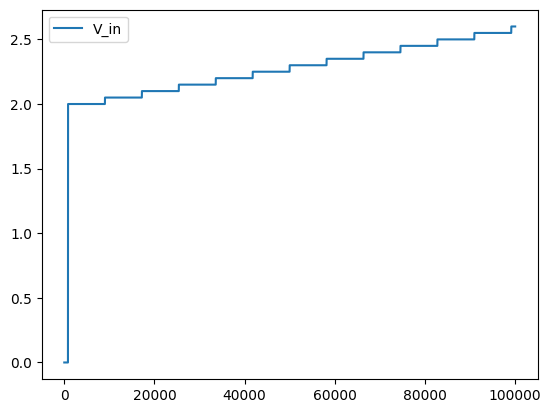

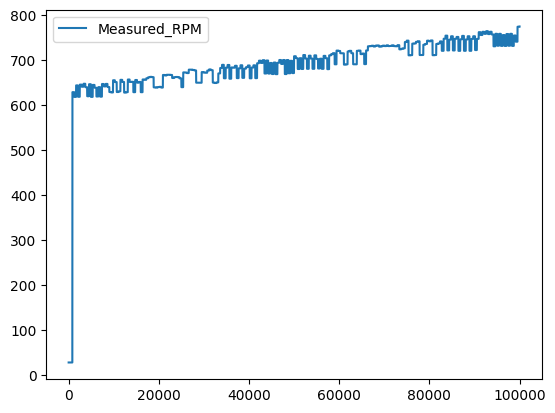

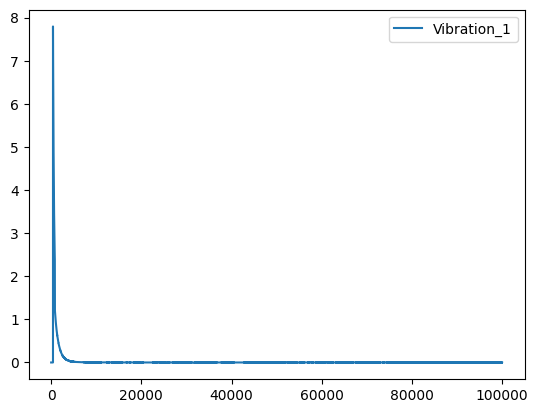

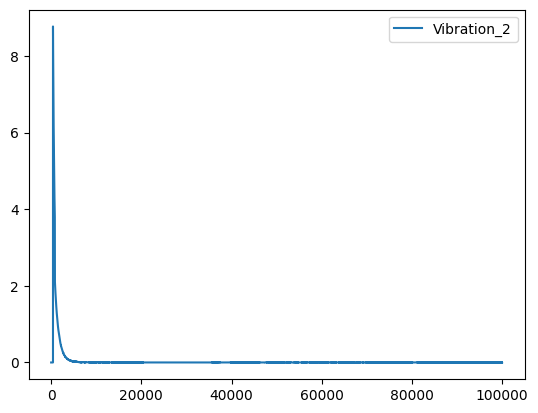

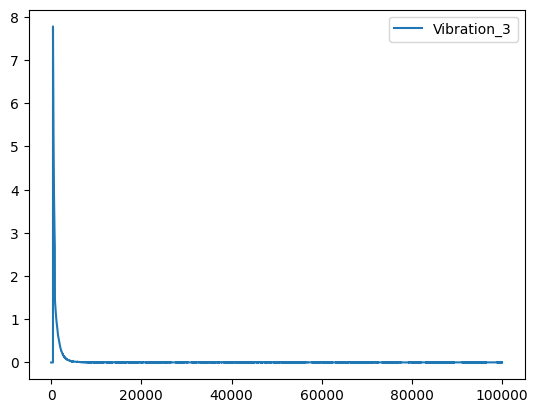

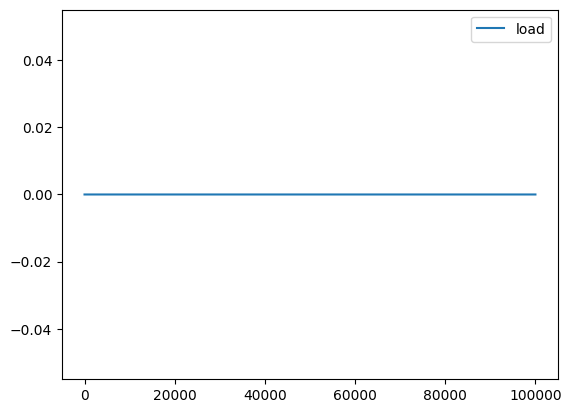

In [92]:
plot_line_from_spark(df_D_spark)

<li> We can filter the data further, to say RPM >  600. This will filter out the spike in vibration signal as well
<li> Based on the voltage and RPM patterns, it looks like the purpose of the experiment was to maintain the motor at specific RPMs. 
<li> We can take the mean of the parameters for each voltage level to understand how the speed and vibration vary with voltage, while also drastically reducing data size. 

In [93]:
df_D_spark=df_D_spark.filter(df_D_spark.Measured_RPM>600)

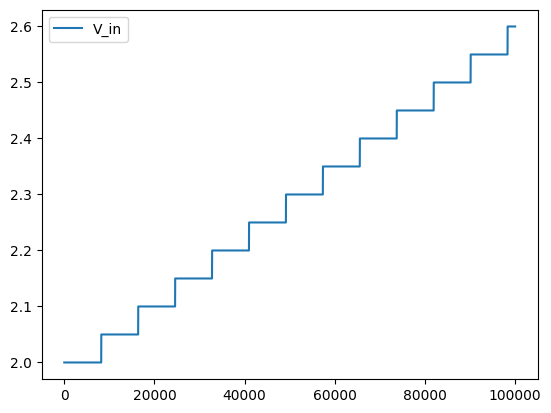

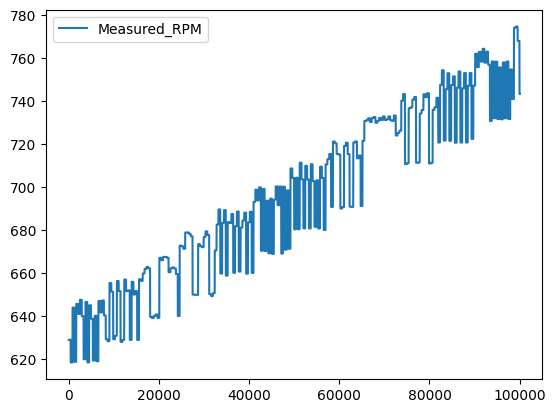

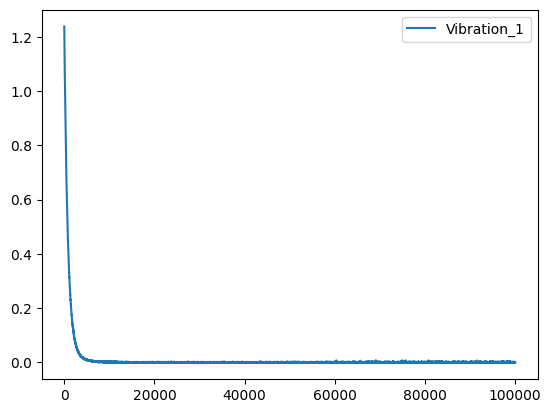

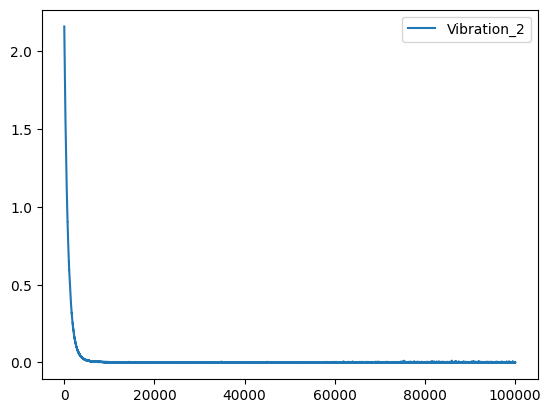

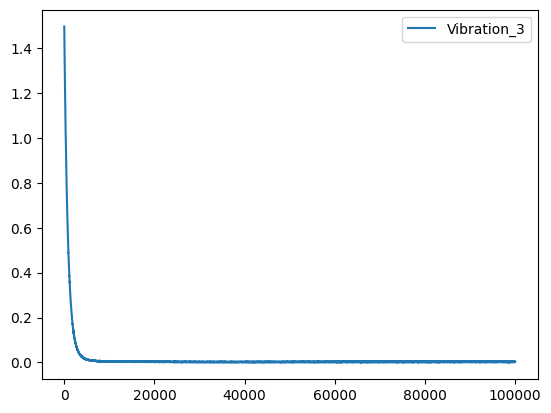

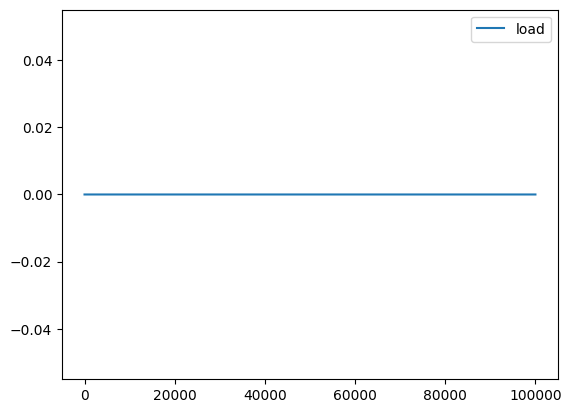

In [94]:
plot_line_from_spark(df_D_spark)

In [95]:
df_D_spark_grouped=df_D_spark.groupBy(['V_in','load']).mean()

'Load' was included in the grouping to prevent getting the mean values of load instead of the actual load values in the df

In [96]:
df_D_spark_grouped.describe().show()

+-------+-----------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+------------------+
|summary|             V_in|              load|         avg(V_in)| avg(Measured_RPM)|    avg(Vibration_1)|    avg(Vibration_2)|    avg(Vibration_3)|         avg(load)|
+-------+-----------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+------------------+
|  count|              805|               805|               805|               805|                 805|                 805|                 805|               805|
|   mean|5.999999999999997|               2.0| 5.999999999999992|1480.2197952421488|0.006343393632915632|0.008040079157754607|0.004384854192235918|               2.0|
| stddev|2.325234701682919|1.4150927751172553|2.3252347016829047|492.42333510183096|0.005665749415115298| 0.00944732536112008|0.004680429372654114|1.4150927751172553

Convert to Pandas

In [97]:
# Let's first convert to pandas
df_D_grouped=df_D_spark_grouped.toPandas()

In [98]:
df_D_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   V_in               805 non-null    float64
 1   load               805 non-null    int32  
 2   avg(V_in)          805 non-null    float64
 3   avg(Measured_RPM)  805 non-null    float64
 4   avg(Vibration_1)   805 non-null    float64
 5   avg(Vibration_2)   805 non-null    float64
 6   avg(Vibration_3)   805 non-null    float64
 7   avg(load)          805 non-null    float64
dtypes: float64(7), int32(1)
memory usage: 47.3 KB


In [99]:
# We can drop the avg V_in and avg load columns and remove 'avg' from the column names
df_D_grouped.columns=[col.replace('avg','').replace('(','').replace(')','') for col in df_D_grouped.columns]
# Remove duplicate columns
df_D_grouped=df_D_grouped.loc[:, ~df_D_grouped.columns.duplicated()]

In [100]:
df_D_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   V_in          805 non-null    float64
 1   load          805 non-null    int32  
 2   Measured_RPM  805 non-null    float64
 3   Vibration_1   805 non-null    float64
 4   Vibration_2   805 non-null    float64
 5   Vibration_3   805 non-null    float64
dtypes: float64(5), int32(1)
memory usage: 34.7 KB


We can see the correlations by plotting a heatmap

<Axes: >

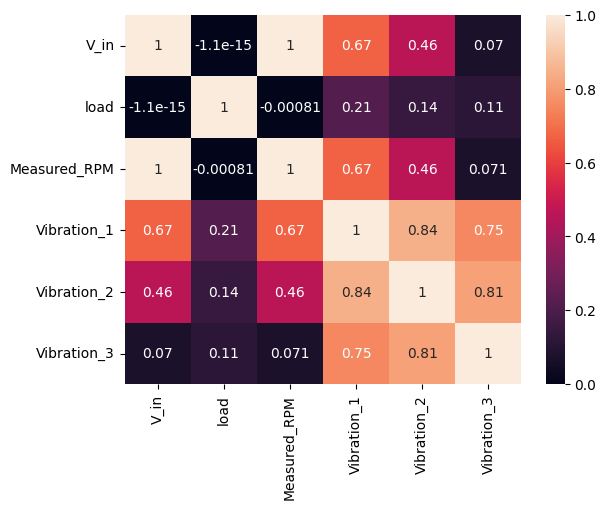

In [101]:
sns.heatmap(df_D_grouped.corr(),annot=True)

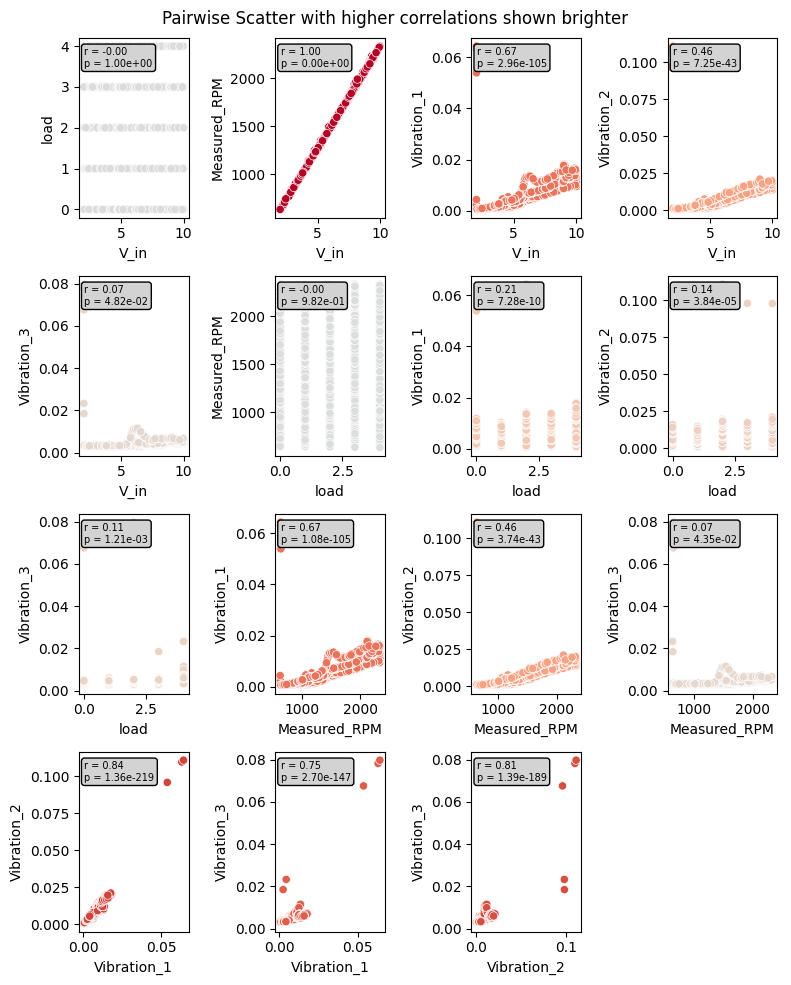

In [102]:
Plotsgrid(df_D_grouped).scatterplots()

<li> The vibration components are correlated weakly to load

V_in
load
Measured_RPM
Vibration_1
Vibration_2
Vibration_3


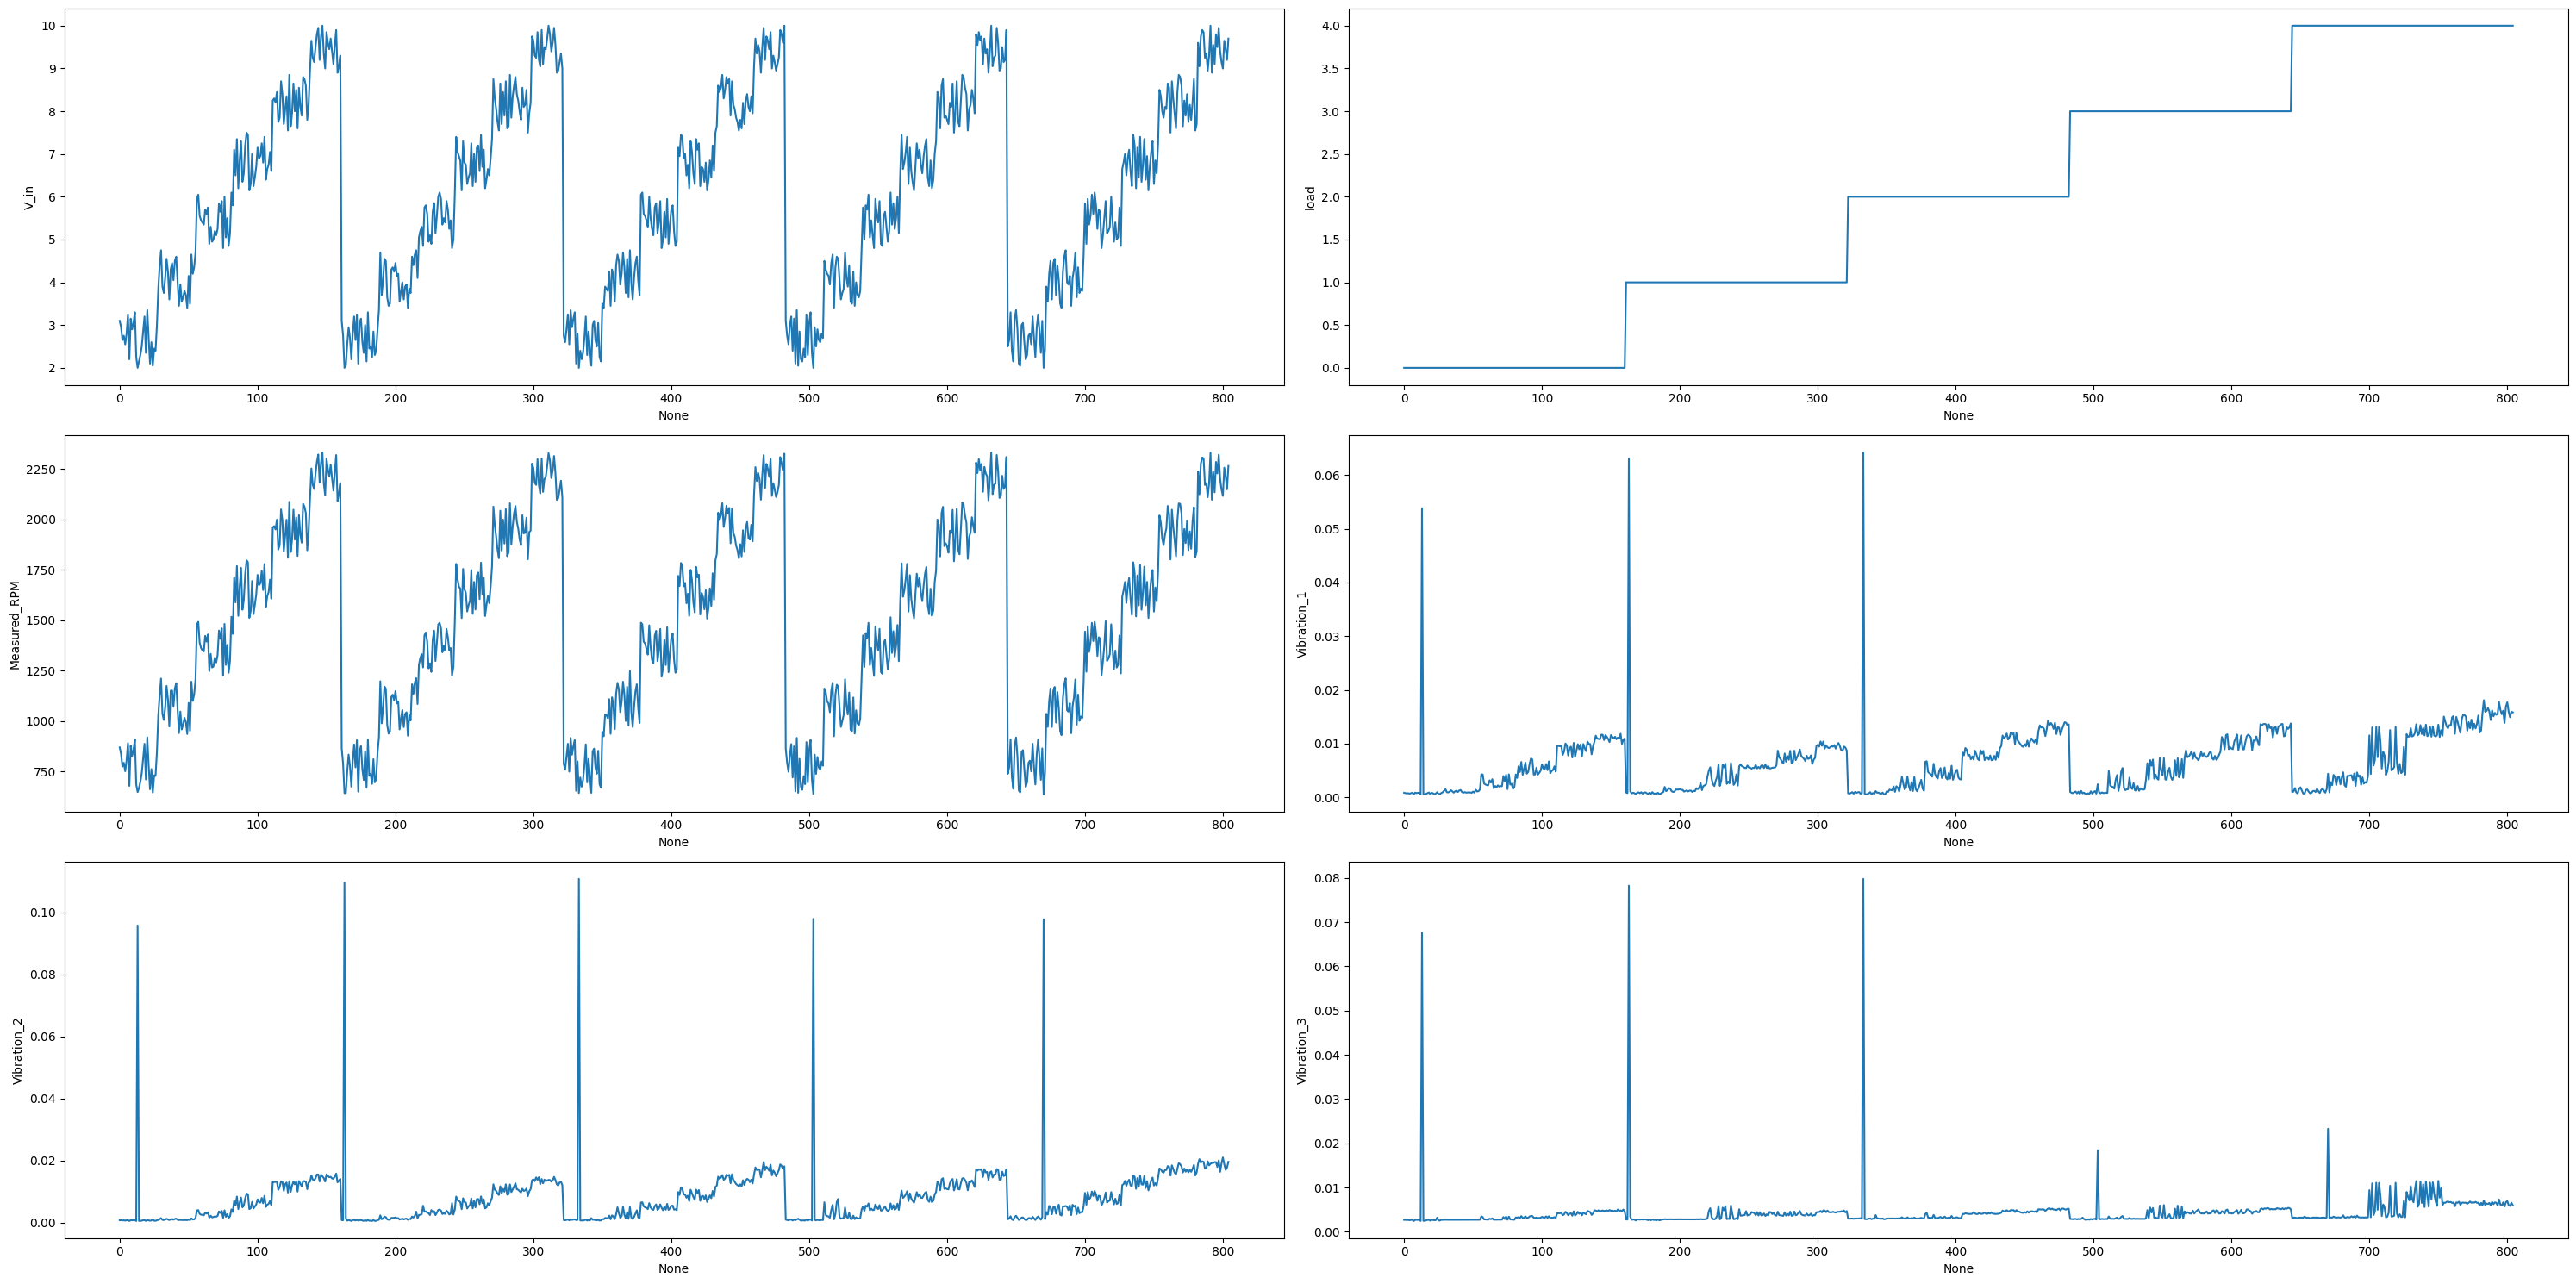

In [103]:
Plotsgrid(df_D_grouped).lineplots();

<li> As the load (unbalance) progresses, the vibrations for the same cycle generally increases with load. This is a small correlation between vibration and load
<li> We also see the vibrations being strongly correlated. This is expected for a rigid shaft. Therefore, we can consider the median value of the vibrations for our analysis

In [104]:
df_D_grouped['Vibration_med']=df_D_grouped[['Vibration_1','Vibration_2','Vibration_3']].median(axis=1)

Make plots for: RPM, median vibration and load

In [105]:
df_D_grouped_featured=df_D_grouped[['Measured_RPM','Vibration_med','load']]

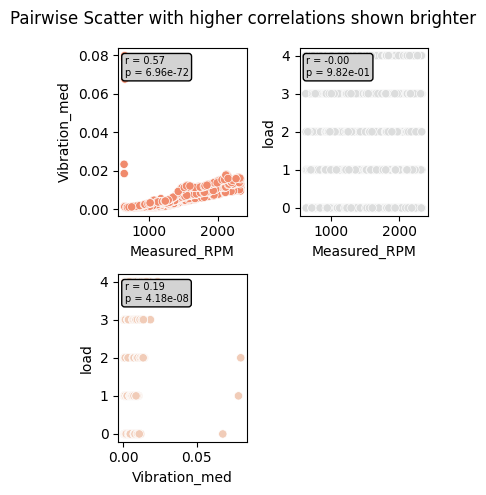

Measured_RPM
Vibration_med
load


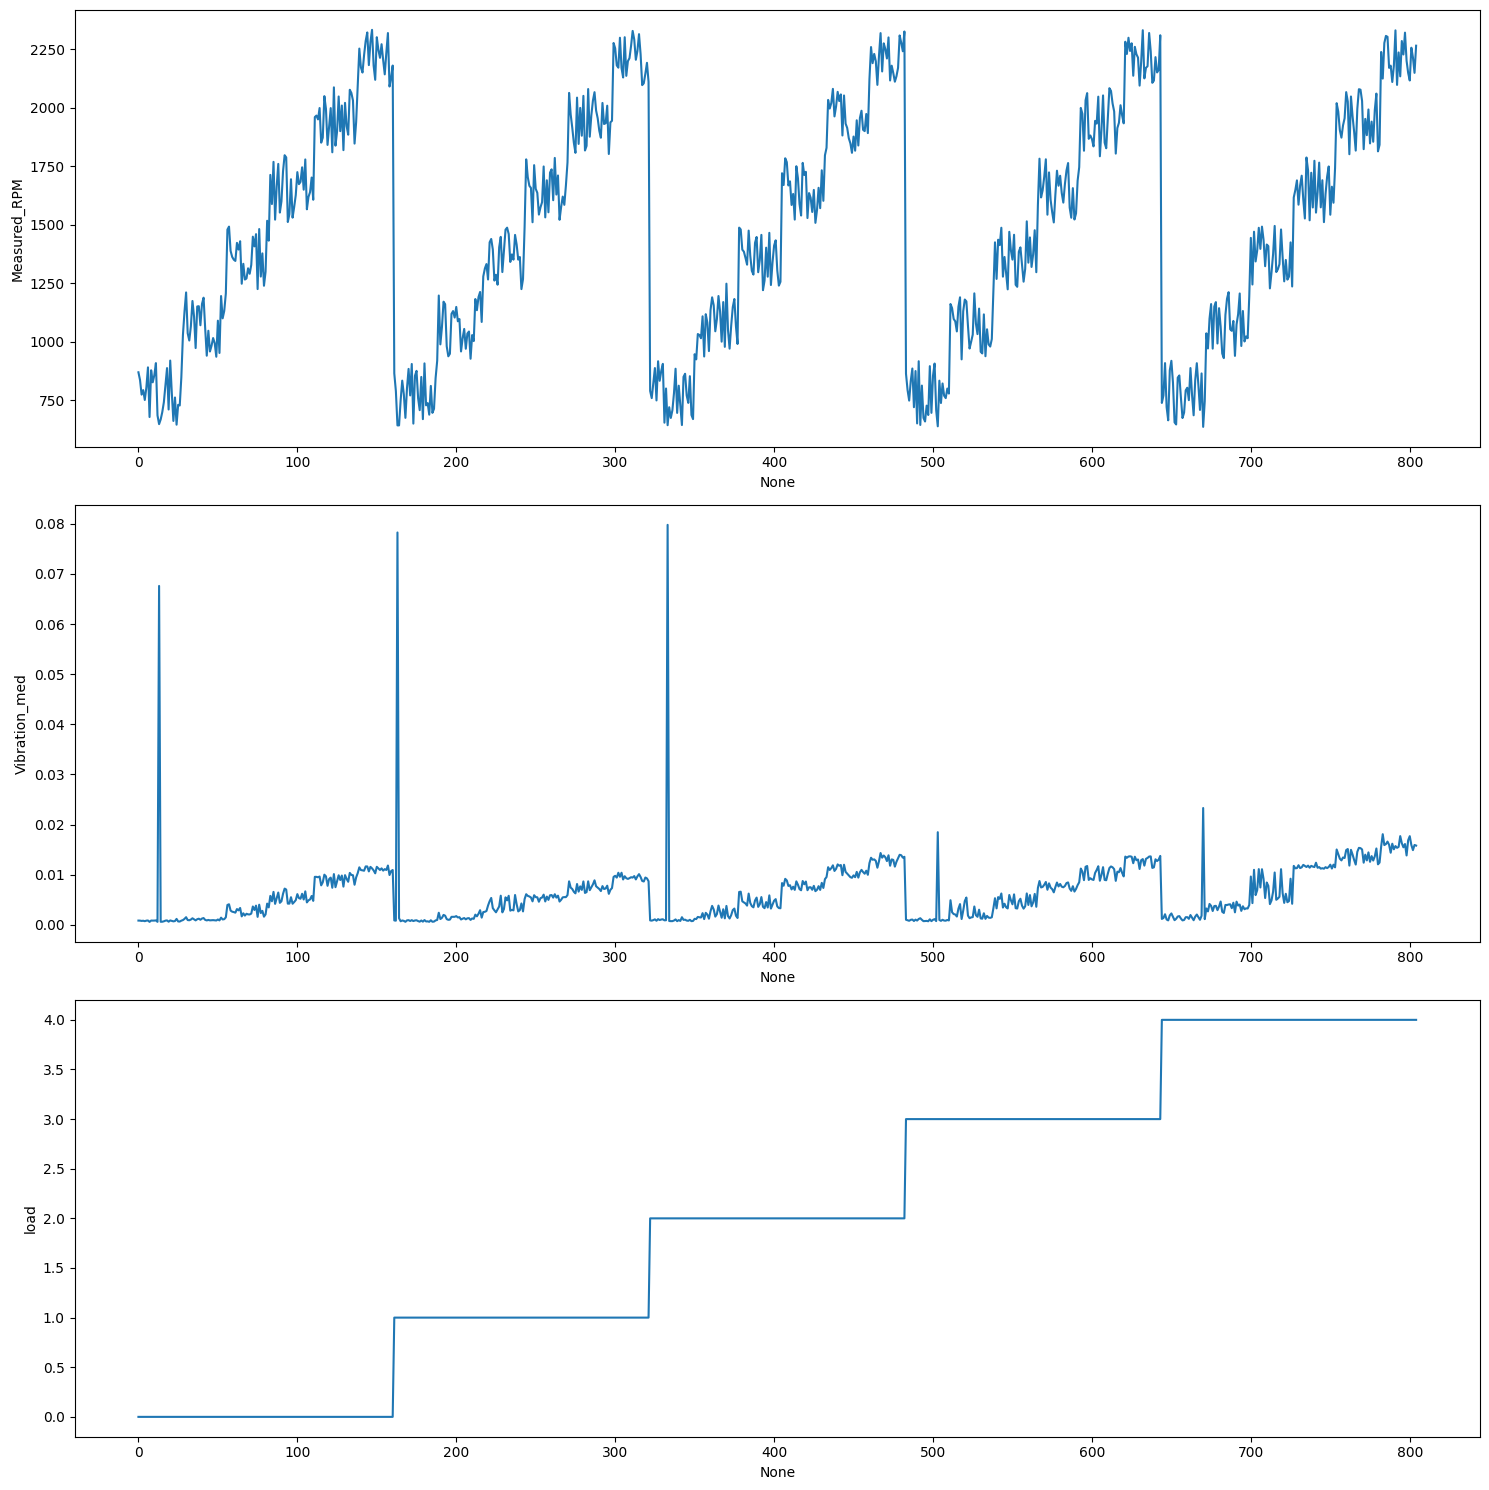

In [106]:
Plotsgrid(df_D_grouped_featured).scatterplots()
Plotsgrid(df_D_grouped_featured).lineplots()

Let's explore also: Vibration vs. RPM for different load levels

<Axes: xlabel='Measured_RPM', ylabel='Vibration_med'>

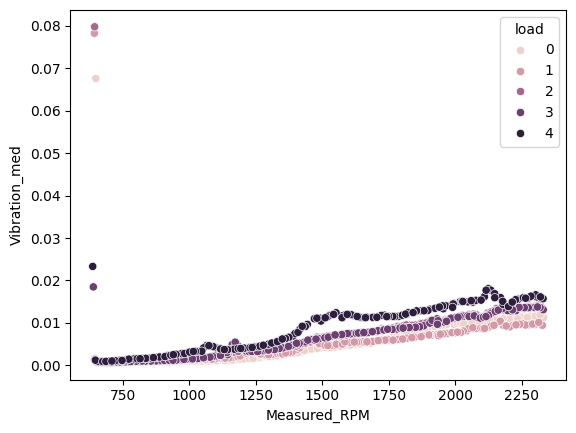

In [107]:
sns.scatterplot(data=df_D_grouped_featured,x='Measured_RPM',y='Vibration_med',hue='load')

<li> The vibrations do indeed rise as load increases, for a given RPM.
<li> The effect is more pronounced between loads 0,1,2 and loads 3,4.
<li> Finally we can filter out RPMs below 1300 as the trend is much stronger above this value. We also get rid of the outlier vibration points at low RPM, likely electrical issues
<br><p><b> Due to the discrete nature of our target variable (unbalance load levels) we can create a classification model to predict the vibration level using the RPM and median vibrations

In [108]:
df_D_grouped_featured=df_D_grouped_featured[df_D_grouped_featured.Measured_RPM>1300]

<Axes: xlabel='Measured_RPM', ylabel='Vibration_med'>

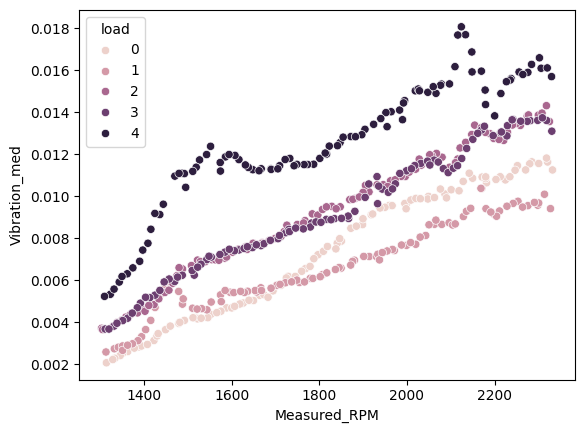

In [109]:
sns.scatterplot(data=df_D_grouped_featured,x='Measured_RPM',y='Vibration_med',hue='load')

<li> There is barely any resolution between load levels 2 and 3. So one would expect the number of true positives here to be fewer
<li> Load level 0 shows <i>more</i> vibration than load level 1 at higher speeds- this is interesting , as one might expect the opposite
<li> Increasing the weight of the load (load 4) has a drastic effect on the vibration characteristics

### <a id='toc1_8_1_'></a>[Data Processing Method Summary](#toc0_)

<ol>
<li> Add a 'load' column corresponding to level of unbalance
<li> Filter for RPM > 1300
<li> Take absolute values of vibrations
<li> Group by 'V_in' and 'load' and remove the additional columns
<li> Calculate median of vibrations 1,2,3
<li> select 'Measured_RPM','Vibration_med' and 'load' columns
</ol>

In [110]:
def process_files(filename):
    ''' Function to read in and process a file to make it compatible for modeling'''
    #print(filename)
    #  Read the file
    spark_df=read_local_csv_object(filenames_E)
    # Remove RPM <1300
    spark_df=spark_df.filter((spark_df.Measured_RPM>=1300))
    # Absolute values for vib
    for col in spark_df.columns:
        if 'Vib' in col:
            spark_df=spark_df.withColumn(col, spark_fn.abs(spark_fn.col(col)))
    # Group by V_in,load
    spark_df=spark_df.groupBy(['V_in','load']).mean()
    # Convert to pandas
    df=spark_df.toPandas()
    # We can drop the avg V_in and avg load columns and remove 'avg' from the column names
    df.columns=[col.replace('avg','').replace('(','').replace(')','') for col in df.columns]
    # Remove duplicate columns
    df=df.loc[:, ~df.columns.duplicated()]
    # Calcuate median of vibrations
    df['Vibration_med']=df[['Vibration_1','Vibration_2','Vibration_3']].median(axis=1)
    # Select RPM, median vibration and load
    df=df[['Measured_RPM','Vibration_med','load']]

    return df


In [111]:
# Create the evaluation df similar to the 'development' df
df_E_grouped_featured=process_files(filenames_E)

['0E_trunc.csv', '1E_trunc.csv', '2E_trunc.csv', '3E_trunc.csv', '4E_trunc.csv']


In [112]:
# Explore the evaluation df
basic_eda(df_E_grouped_featured)


COLUMNS LIST: 
['Measured_RPM', 'Vibration_med', 'load']

FIRST FEW: 
   Measured_RPM  Vibration_med  load
0   1353.860217       0.002436     0
1   1346.793309       0.002245     0
2   1324.485053       0.002017     0

LAST FEW: 
     Measured_RPM  Vibration_med  load
152   1932.797451       0.014683     4
153   1882.744901       0.015137     4
154   1874.222343       0.014631     4

INFO: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Measured_RPM   155 non-null    float64
 1   Vibration_med  155 non-null    float64
 2   load           155 non-null    int32  
dtypes: float64(2), int32(1)
memory usage: 3.2 KB
None

DESCRIPTION: 
       Measured_RPM  Vibration_med        load
count    155.000000     155.000000  155.000000
mean    1606.787468       0.006569    2.000000
std      187.591119       0.003363    1.418798
min     1307.750927    

['Measured_RPM', 'Vibration_med', 'load']

<Axes: xlabel='Measured_RPM', ylabel='Vibration_med'>

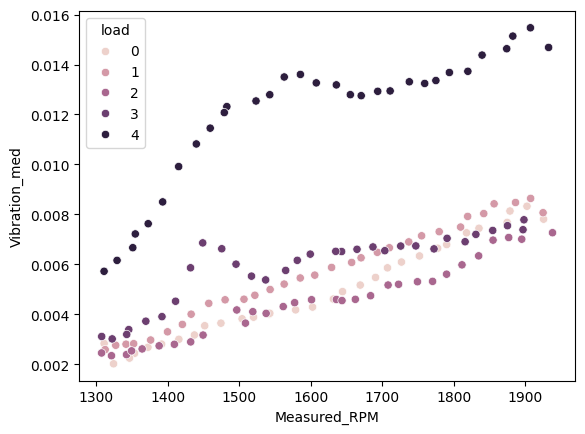

In [113]:
sns.scatterplot(data=df_E_grouped_featured,x='Measured_RPM',y='Vibration_med',hue='load')

<li> The resolution between lines for the training and test sets is very different. The lower levels of loading in the test set are barely distinguishable
<li> This suggests that the train set may not be a  good representation of the population, or that the test set is not representative of the population.
<li> To obtain a better representation, we could try to combine the entire data ('D'+'E') and obtain new train and test sets by splitting and random shuffling

## <a id='toc1_9_'></a>[Model Data Preparation](#toc0_)

target_col='load'
feature_cols=[col for col in df_D_grouped_featured.columns if col != target_col]
labels=np.unique(df_D_grouped_featured.load)
################################
X_train,y_train,X_test,y_test=df_D_grouped_featured[feature_cols].values,df_D_grouped_featured[target_col].values,
df_E_grouped_featured[feature_cols].values,df_E_grouped_featured[target_col].values

In [114]:
target_col='load'
feature_cols=[col for col in df_D_grouped_featured.columns if col != target_col]
labels=np.unique(df_D_grouped_featured.load)
###########################
df_grouped_combined=pd.concat([df_D_grouped_featured,df_E_grouped_featured],axis=0)
X=df_grouped_combined[feature_cols]
y=df_grouped_combined[target_col]
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=.7,shuffle=True)
################################

<Axes: xlabel='RPM', ylabel='Vib'>

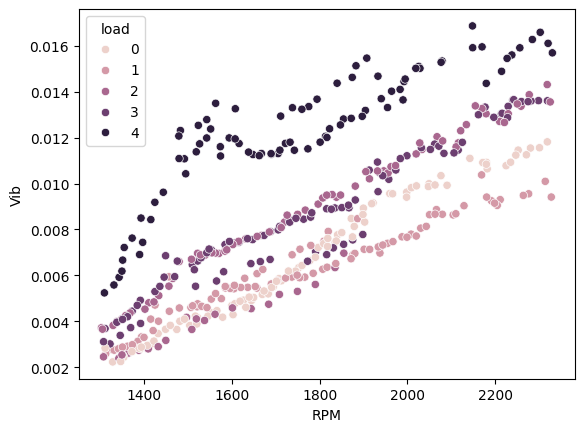

In [115]:
df_vib_scatter=pd.concat([X_train,y_train],axis=1)
df_vib_scatter.columns=['RPM','Vib','load']
sns.scatterplot(data=df_vib_scatter,x='RPM',y='Vib',hue='load')

<Axes: xlabel='RPM', ylabel='Vib'>

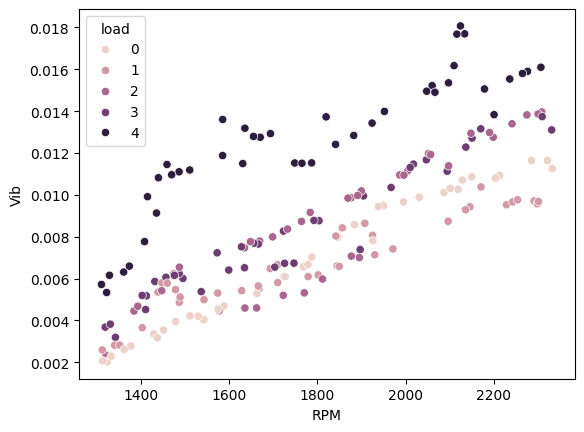

In [116]:
df_vib_scatter=pd.concat([X_test,y_test],axis=1)
df_vib_scatter.columns=['RPM','Vib','load']
sns.scatterplot(data=df_vib_scatter,x='RPM',y='Vib',hue='load')

<li> Although not perfect, the train and test sets share a better similarity of characteristic lines
<li> This suggests that there was some unnoticed bias in the earlier data, which seems to have been addressed to some extent by combining and shuffling

## <a id='toc1_10_'></a>[Model Evaluation](#toc0_)

<li> Favorable: The higher load levels are accurately predicted to prevent imminent damage (TP) - Sum of [(3,3),(4,4)]
<li> Unfavorable: The higher load levels are predicted as lower loads (FN) - Sum of [(0,3),(1,3),(0,4),(1,4)]
<li> Unfavorable: The lower load levels are mistaken as higher loads leading to false flags - Sum of [(3,0),(3,1),(4,1),(4,2)]

In [117]:
def evaluate_classifier(models_dict):
    roc_dict={}
    for model,params in models_dict.items():
        model_steps=[
            ('Scaler',MinMaxScaler()), # MinMaxScaler because the vibration and engine speed  are in different scales
            ('Model',model)
        ]
        # Set parameters
        params={'Model__'+k:v for k,v in params.items()} 
        # Create Pipeline
        pipeline=Pipeline(model_steps)
        # GSCV
        search=GridSearchCV(estimator=pipeline,param_grid=params,cv=10,scoring='accuracy')
        # Define local model using pipeline
        search.fit(X_train,y_train)
        print('\n',model.__class__.__name__,'\n','Best Score, Best Params: ',search.best_score_,search.best_params_)
        # Predict
        y_pred_prob = search.predict_proba(X_test)
        y_pred_class = search.predict(X_test)
        
        #### Plot Confusion Matrix with Percentages
        conf_matrix = confusion_matrix(y_test, y_pred_class, labels=labels)
        
        # Convert the confusion matrix to percentages
        conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
        conf_matrix_percent=np.floor(conf_matrix_percent)
        
        # Create display object
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent, display_labels=labels)
        
        # Plot the confusion matrix
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix with Percentages: {model.__class__.__name__}')
        plt.show()

        # Classification metrics
        class_report=classification_report(y_test,y_pred_class,output_dict=True,labels=labels)
        df_class_report=pd.DataFrame(class_report).T
        print(df_class_report) 
        # ROC curve
        #fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
        #roc_auc = auc(fpr, tpr)
        #roc_dict[model]=[fpr,tpr,roc_auc]
        
        ### Calculate Favorable and Unfavorable Predictions
        favorable = conf_matrix[3, 3] + conf_matrix[4, 4]
        
        # Unfavorable 1: Higher load levels predicted as lower loads
        unfavorable_1 = (conf_matrix[0, 3] + conf_matrix[1, 3] + 
                         conf_matrix[0, 4] + conf_matrix[1, 4])
        
        # Unfavorable 2: Lower load levels mistaken as higher loads
        unfavorable_2 = (conf_matrix[3, 0] + conf_matrix[3, 1] + 
                         conf_matrix[4, 1] + conf_matrix[4, 2])
        
        # Calculate Favorable/(Favorable + Unfavorable1 + Unfavorable2)
        model_score = favorable / (favorable + unfavorable_1 + unfavorable_2)
        
        # Print the ratio
        print(f'Model Score (Higher is better): {model_score:.4f}')
    return roc_dict

In [118]:
# List of models to evaluate
models_dict={
    RandomForestClassifier():{'n_estimators':[50,100,150],'max_depth':[2,5,10,15]},
    KNeighborsClassifier():{'n_neighbors':[5,10,15]},
    XGBClassifier():{'booster':['gbtree','gblinear','dart'],'n_estimators':[50,100,150]},
    LogisticRegression():{'C':[2,5,10,25,50,100],'max_iter':[100,200]}
    }


 RandomForestClassifier 
 Best Score, Best Params:  0.6251515151515152 {'Model__max_depth': 15, 'Model__n_estimators': 50}


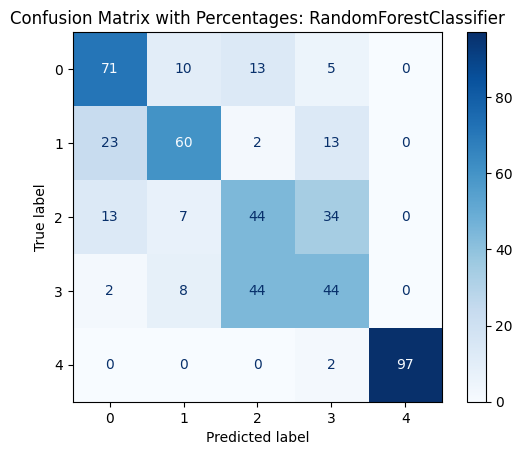

              precision    recall  f1-score     support
0              0.642857  0.710526  0.675000   38.000000
1              0.696970  0.605263  0.647887   38.000000
2              0.435897  0.447368  0.441558   38.000000
3              0.432432  0.444444  0.438356   36.000000
4              1.000000  0.976190  0.987952   42.000000
accuracy       0.645833  0.645833  0.645833    0.645833
macro avg      0.641631  0.636759  0.638151  192.000000
weighted avg   0.651277  0.645833  0.647519  192.000000
Model Score (Higher is better): 0.8382

 KNeighborsClassifier 
 Best Score, Best Params:  0.6762626262626263 {'Model__n_neighbors': 5}


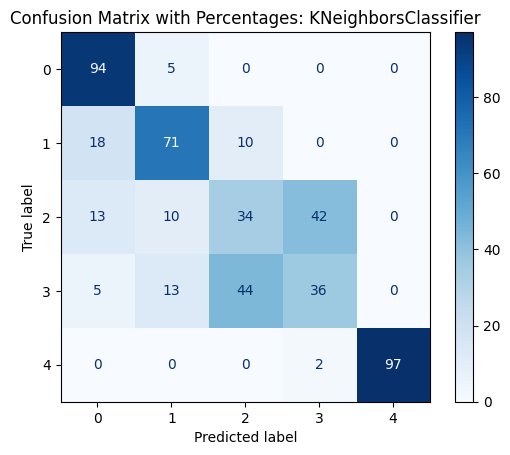

              precision    recall  f1-score     support
0              0.720000  0.947368  0.818182   38.000000
1              0.710526  0.710526  0.710526   38.000000
2              0.393939  0.342105  0.366197   38.000000
3              0.433333  0.361111  0.393939   36.000000
4              1.000000  0.976190  0.987952   42.000000
accuracy       0.677083  0.677083  0.677083    0.677083
macro avg      0.651560  0.667460  0.655359  192.000000
weighted avg   0.661092  0.677083  0.665011  192.000000
Model Score (Higher is better): 0.8852

 XGBClassifier 
 Best Score, Best Params:  0.5961111111111111 {'Model__booster': 'gbtree', 'Model__n_estimators': 100}


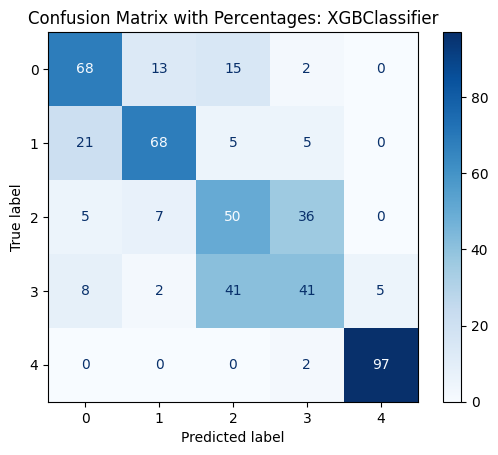

              precision    recall  f1-score     support
0              0.666667  0.684211  0.675325   38.000000
1              0.742857  0.684211  0.712329   38.000000
2              0.452381  0.500000  0.475000   38.000000
3              0.454545  0.416667  0.434783   36.000000
4              0.953488  0.976190  0.964706   42.000000
accuracy       0.661458  0.661458  0.661458    0.661458
macro avg      0.653988  0.652256  0.652428  192.000000
weighted avg   0.662305  0.661458  0.661201  192.000000
Model Score (Higher is better): 0.8889

 LogisticRegression 
 Best Score, Best Params:  0.5645454545454545 {'Model__C': 10, 'Model__max_iter': 100}


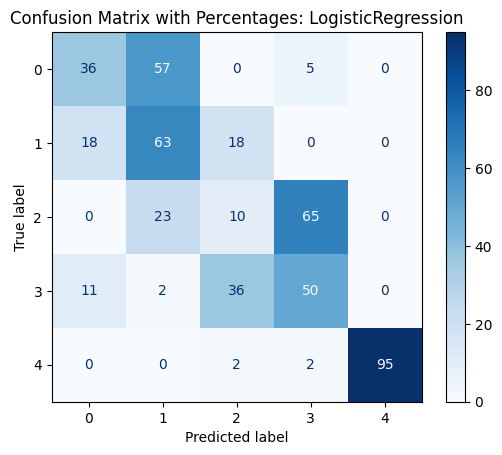

              precision    recall  f1-score     support
0              0.560000  0.368421  0.444444   38.000000
1              0.428571  0.631579  0.510638   38.000000
2              0.160000  0.105263  0.126984   38.000000
3              0.391304  0.500000  0.439024   36.000000
4              1.000000  0.952381  0.975610   42.000000
accuracy       0.520833  0.520833  0.520833    0.520833
macro avg      0.507975  0.511529  0.499340  192.000000
weighted avg   0.519441  0.520833  0.509891  192.000000
Model Score (Higher is better): 0.8788


In [119]:
roc_dict=evaluate_classifier(models_dict)

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Model Scores</title>
    <style>
        table {
            width: 100%;
            border-collapse: collapse;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
        }
        tr:hover {
            background-color: #f1f1f1;
        }
    </style>
</head>
<body>

<h2>Model Scores</h2>
<table>
    <tr>
        <th>Model</th>
        <th>Score</th>
    </tr>
    <tr>
        <td>RF</td>
        <td>0.83</td>
    </tr>
    <tr>
        <td>KNN Classifier</td>
        <td>0.89</td>
    </tr>
    <tr>
        <td>XGB Classifier</td>
        <td>0.89</td>
    </tr>
    <tr>
        <td>Logistic Regressor</td>
        <td>0.88</td>
    </tr>
</table>

</body>
</html>

<p>Although KNN, XGB, and Logistic Regressor give very similar scores and better than RF, indicating all reasonable models, we can use a combination of model outputs for best results:</p>

<ol>
    <li>While KNN has significantly higher accuracy than others at level 0 (no unbalance), XGB outperforms KNN at almost all other levels, while managing to not falsely predict higher levels. Due to its higher accuracy at level 0, KNN can be used to overrule XGB if it predicts a zero.</li>
    <li>XGB regressor is better than others in the critical region of classes 2 and 3, where the predictions are poor (due to low resolution as seen before). Hence, XGB can be used for the other levels.</li>
    <li>Logistic Regressor has poor TP at level 2.</li>
</ol>

<p>Hence, we can use the XGB regressor but consider KNN for the case of no unbalance prediction.</p>

## <a id='toc1_11_'></a>[Concern areas](#toc0_)

<li> A lot of the level 2 loadings are being predicted as level 3. This should be kept in mind.
<li> The setup and/or data can be explored more to understand why the vibration for level 0 is greater than level 1 loading. Was there already some unbalance prior to loading? This is not expected and can potentially complicate the experiment and model results. 


## <a id='toc1_12_'></a>[Suggestions and Improvements](#toc0_)

<li> Due to the difficulty of resolving levels 2 and 3, different mass and/or radius could be tried. We could also try to orient the sensors differently to see if they produce sufficiently different characteristics or provide more information to help resolve the levels better.
<li> The setup can be explored more to understand why the vibration for level 1 is less than level 0 loading as this can potentially skew  the results. 
